# Testing local GPU vs. Colab GPUs performance using Resnet18 classifier on CIFAR-100 dataset with PyTorch




In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
import numpy as np
import pandas as pd
import re
import os

In [2]:
# Settings and parameters

# Runtime settings
local_runtime = True    # local runtime with CUDA on Win10
use_gpu = True
gdrive_mounted = True

# Try to use CUDA only if available
gpu_selected_and_available = use_gpu & torch.cuda.is_available()

# Experiment parameters
batch_size = 64
learning_rate = 1e-3
num_epochs = 10
selected_criterion = nn.CrossEntropyLoss
selected_optimizer = optim.SGD

In [3]:
# Print backend info

print('Backend info:')

if local_runtime:
    if gpu_selected_and_available:
        !nvidia-smi
    else:
        !wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status
else:
    if gpu_selected_and_available:
        !nvidia-smi
    else:
        !cat /proc/cpuinfo

Backend info:


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Directory settings - restart runtime if runtime settings changed!

if not local_runtime:
    if gdrive_mounted:
        work_dir = '/content/drive/My Drive/GPU_tests/Resnet_GPU_tests'
    else:
        work_dir = '/content/GAN_GPU_tests'
else:
    work_dir = 'C://Projects//GPU_tests//Resnet_GPU_tests'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

if gpu_selected_and_available:
    if local_runtime:
        device_name = !nvidia-smi --query-gpu=name --format=csv,noheader
        device_name = device_name[0]
    else:
        device_name = !nvidia-smi --query-gpu=name --format=csv,noheader
        device_name = device_name[0]
else:
    if local_runtime:
        device_name = 'Local_CPU'
    else:
        device_name = 'Colab_CPU'

data_path = os.path.join(os.getcwd(), 'data')
save_dir = os.path.join(os.getcwd(), 'results',
                        re.sub(' ', '_', device_name) + '_' +\
                        re.sub('-| |:', '', str(datetime.now()).split('.')[0]))
os.makedirs(save_dir, exist_ok=True)

In [5]:
# Load PyTorch implementation of Resnet18

model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\matowy/.cache\torch\checkpoints\resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Adapt last layer for 100 classes instead of 1000

model.fc = nn.Linear(in_features=512, out_features=100, bias=True)

if gpu_selected_and_available:
    model.cuda()
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Define data transformations

trs = transforms.Compose([  
    transforms.Resize(260),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [8]:
# Load and transform training and validation datasets

train_dataset = datasets.CIFAR100(data_path, train=True,
                                  transform=trs, download=True)
valid_dataset = datasets.CIFAR100(data_path, train=False,
                                  transform=trs, download=True)

Extracting C:\Projects\GPU_tests\Resnet_GPU_tests\data\cifar-100-python.tar.gz to C:\Projects\GPU_tests\Resnet_GPU_tests\data
Files already downloaded and verified


In [9]:
# Create data loaders

train_data_gen = torch.utils.data.DataLoader(train_dataset, batch_size,
                                             num_workers=1, pin_memory=False)
valid_data_gen = torch.utils.data.DataLoader(valid_dataset, batch_size,
                                             num_workers=1, pin_memory=False)

dataloaders = {'train': train_data_gen,
               'valid': valid_data_gen}

dataset_sizes = {'train': len(train_data_gen.dataset),
                 'valid': len(valid_data_gen.dataset)}

In [10]:
# Loss function and optimizer

criterion = selected_criterion()
optimizer = selected_optimizer(model.parameters(), lr=learning_rate)

In [11]:
# Training procedure

def train_model(model, criterion, optimizer, num_epochs=1):

    best_model_weigths = model.state_dict()
    best_acc = 0.0

    stats = {'Epoch': [],
             'Epoch_time': [],
             'Epoch_train_loss': [],
             'Epoch_valid_loss': [],
             'Epoch_train_accuracy': [],
             'Epoch_valid_accuracy': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        t0 = time()
        # stat_dic = {}

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data

                if next(model.parameters()).is_cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Record statistics
                running_loss += loss.detach().item()
                running_corrects += torch.sum(preds == labels.data).detach().item()

            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
                stats['Epoch_train_loss'].append(epoch_loss)
                stats['Epoch_train_accuracy'].append(epoch_acc)
                print(f'Training loss: {epoch_loss:.4f}\n'
                      f'Training accuracy: {epoch_acc:.4f}')
            else:
                stats['Epoch_valid_loss'].append(epoch_loss)
                stats['Epoch_valid_accuracy'].append(epoch_acc)
                print(f'Validation loss: {epoch_loss:.4f}\n'
                      f'Validation accuracy: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weigths = model.state_dict()
        
        stats['Epoch'].append(epoch + 1)
        epoch_time = time() - t0
        stats['Epoch_time'].append(epoch_time)
        print(f'Epoch time: {epoch_time:.1f} secs')
        print()

    total_time = sum(stats['Epoch_time'])
    print('Training complete in {:.0f}m {:.0f}s'.format(
           total_time // 60, total_time % 60))
    print(f'Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_weigths)
    return model, stats

In [12]:
# Run training

model, stats = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------
Training loss: 0.0691
Training accuracy: 0.0596
Validation loss: 0.0640
Validation accuracy: 0.1382
Epoch time: 266.7 secs

Epoch 2/10
----------
Training loss: 0.0586
Training accuracy: 0.2120
Validation loss: 0.0535
Validation accuracy: 0.2814
Epoch time: 269.8 secs

Epoch 3/10
----------
Training loss: 0.0491
Training accuracy: 0.3402
Validation loss: 0.0447
Validation accuracy: 0.3878
Epoch time: 271.2 secs

Epoch 4/10
----------
Training loss: 0.0416
Training accuracy: 0.4350
Validation loss: 0.0382
Validation accuracy: 0.4592
Epoch time: 266.2 secs

Epoch 5/10
----------
Training loss: 0.0360
Training accuracy: 0.5002
Validation loss: 0.0334
Validation accuracy: 0.5140
Epoch time: 264.7 secs

Epoch 6/10
----------
Training loss: 0.0318
Training accuracy: 0.5464
Validation loss: 0.0300
Validation accuracy: 0.5522
Epoch time: 264.5 secs

Epoch 7/10
----------
Training loss: 0.0287
Training accuracy: 0.5813
Validation loss: 0.0273
Validation accuracy: 0.5851
Ep

In [13]:
# Save stats
stats_df = pd.DataFrame(stats)
stats_df.to_csv(os.path.join(save_dir, 'stats.csv'), index=False)

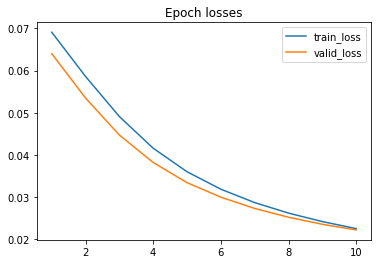

In [14]:
# Print and save epoch losses plot
plt.plot(stats['Epoch'], stats['Epoch_train_loss'])
plt.plot(stats['Epoch'], stats['Epoch_valid_loss'])
plt.title('Epoch losses')
plt.legend(['train_loss', 'valid_loss'])
plt.savefig(os.path.join(save_dir, 'epoch_losses.png'))

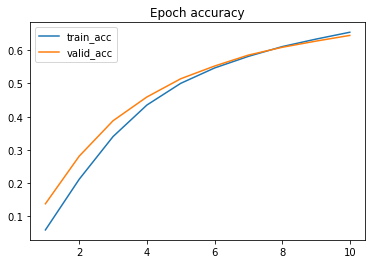

In [15]:
# Print and save epoch accuracy plot
plt.plot(stats['Epoch'], stats['Epoch_train_accuracy'])
plt.plot(stats['Epoch'], stats['Epoch_valid_accuracy'])
plt.title('Epoch accuracy')
plt.legend(['train_acc', 'valid_acc'])
plt.savefig(os.path.join(save_dir, 'epoch_accuracy.png'))

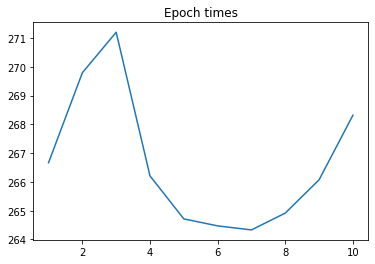

In [16]:
# Print and save epoch times plot
plt.plot(stats['Epoch'], stats['Epoch_time'])
plt.title('Epoch times')
plt.savefig(os.path.join(save_dir, 'epoch_times.png'))